In [51]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import MCXGate, RYGate, CZGate, XGate
from math import ceil, log2, pi, asin
import numpy as np
from qiskit_aer import AerSimulator

In [53]:
def binary_rep(val, t):
    """
    Convert a real number in (-1, 1) to a custom binary representation using t bits.
    
    This function implements a specialized binary encoding scheme that represents
    real numbers using a sign bit, exponent encoding, and fractional part encoding.
    The encoding is designed for quantum amplitude representation where values
    must be normalized and efficiently encoded in a fixed number of qubits.
    
    Binary Format Structure:
    - Bit 0: Sign bit (0 for positive, 1 for negative)
    - Bits 1 to j-1: Implicit zeros (exponent encoding via position)
    - Bit j: Implicit leading 1 (marks the most significant fractional bit)
    - Bits j+1 to t-1: Binary fractional part
    
    Args:
        val (float): Input value that must satisfy -1 < val < 1
        t (int): Total number of bits for the binary representation
    
    Returns:
        numpy.ndarray: Binary array of length t representing the input value
        
    Example:
        For val = 0.375 = 3/8 = 0.011₂ and t = 6:
        - Sign: 0 (positive)
        - Normalize: 0.375 * 4 = 1.5 (shift to [1,2) range)
        - j = 2 (position of leading 1)
        - Result: [0, 0, 1, 1, 0, 0] representing the fractional encoding
    """
    
    # Input validation: ensure value is in the valid range
    assert abs(val) < 1, "Input value must be in (-1, 1)"
    
    # Initialize the binary representation array
    r = np.zeros(t, dtype=int)
    
    ##########################################
    # SIGN BIT ENCODING
    ##########################################
    # Store the sign in the first bit
    if val >= 0:
        r[0] = 0  # Positive values
    else:
        r[0] = 1  # Negative values
    
    ##########################################
    # MAGNITUDE NORMALIZATION
    ##########################################
    # Initialize exponent counter and work with absolute value
    p = 1           # Exponent counter (tracks powers of 2)
    y = abs(val)    # Work with magnitude only
    
    # Normalize y to the range [1, 2) by finding the appropriate power of 2
    # This is equivalent to finding the position of the most significant bit
    while y < 1 and y != 0:
        y *= 2      # Left shift (multiply by 2)
        p -= 1      # Decrease exponent (we're shifting left)
    
    ##########################################
    # EXPONENT ENCODING VIA BIT POSITION
    ##########################################
    # Calculate the position j where the leading 1 should be placed
    # j represents the bit position of the most significant fractional bit
    j = 1 - p
    
    # Set leading zeros for the exponent encoding
    if j >= 0:
        r[1:j] = 0  # Fill positions 1 to j-1 with zeros
    else:
        r[1:] = 0   # If j < 0, fill all remaining positions with zeros
    
    # Place the implicit leading 1 at position j (if within bounds)
    if 0 <= j < t:
        r[j] = 1
    
    # Remove the integer part (leading 1) to get the fractional part
    y -= 1
    
    ##########################################
    # FRACTIONAL PART BINARY ENCODING
    ##########################################
    # Encode the fractional part using standard binary representation
    # Each iteration extracts the next binary digit of the fraction
    for k in range(j + 1, t):
        y *= 2          # Shift fractional part left (equivalent to y * 2)
        if y >= 1:      # If the shifted value >= 1, this bit is 1
            r[k] = 1
            y -= 1      # Remove the integer part
        else:           # Otherwise, this bit is 0
            r[k] = 0
    
    return r

In [55]:

def generate_control_state_strings(n):
    """
    Generate all possible control states for n control qubits as binary strings.
    
    Returns:
        List of strings representing each control state.
    """
    num_states = 2**n
    control_state_strings = [format(i, f'0{n}b') for i in range(num_states)]
    return control_state_strings

def generate_Diagonal_Block_Encoding_routine(n,t,Angles):
    """
    Generate a quantum circuit for diagonal block encoding using a unitary block encoding technique.
    
    This function implements a block encoding scheme where a diagonal matrix is encoded into
    a larger unitary matrix using ancilla qubits and controlled operations.
    
    Args:
        n (int): Number of index qubits (controls the dimension of the diagonal matrix: 2^n x 2^n)
        t (int): Number of ancilla qubits used for the block encoding
        Angles (list): A 2^n length list where each element is a t-length array specifying
                      which ancilla qubits to activate for each basis state
    
    Returns:
        QuantumCircuit: The complete block encoding circuit with encoder + oracle + encoder†
    """
    
    # Define the quantum register sizes
    idx_qubits = n      # Index qubits that represent the computational basis states
    t_qubits = t        # Ancilla qubits used for encoding the diagonal values
    data_qubits = 1     # Single data qubit that the diagonal operation acts upon
    
    # Create quantum registers for different purposes
    iq = QuantumRegister(idx_qubits, "idx")    # Index register for basis state selection
    tq = QuantumRegister(t_qubits, "t")        # Ancilla register for amplitude encoding
    dq = QuantumRegister(data_qubits, "data")  # Data register for the target operation
    
    # Generate all possible control state strings (binary representations of 0 to 2^n - 1)
    ctrl_states = generate_control_state_strings(n)
    
    ##########################################
    # ENCODER CIRCUIT: Maps computational basis states to ancilla configurations
    ##########################################
    encoder = QuantumCircuit(iq, tq, dq)
    
    # For each computational basis state |i⟩
    for index, state in enumerate(ctrl_states):
        # For each ancilla qubit position
        for position, element in enumerate(Angles[index]):
            # If this ancilla should be activated for basis state |i⟩
            if element == 1:
                # Apply multi-controlled X gate: |i⟩|0⟩ → |i⟩|1⟩ for ancilla at 'position'
                encoder.mcx(iq, tq[position], ctrl_state=state)
    
    ##########################################
    # ORACLE CIRCUIT: Implements the diagonal operation on encoded states
    ##########################################
    Oracle = QuantumCircuit(iq, tq, dq)
    
    # First ancilla controls a Z rotation (phase flip)
    Oracle.cz(tq[0], dq)
    
    # Remaining ancillas control Y rotations with geometrically decreasing angles
    for index in range(1, t_qubits):
        # Angle decreases as π/2^(k-1) for k-th ancilla (k=1,2,3,...)
        angle = np.pi / (2 ** (index - 1))
        # Controlled rotation about Y-axis
        Oracle.cry(angle, tq[index], dq)
    Oracle.x(dq)
    
    ##########################################
    # COMPLETE BLOCK ENCODING CIRCUIT: U = Encoder† · Oracle · Encoder
    ##########################################
    
    # Initialize the full quantum circuit
    qc = QuantumCircuit(iq, tq, dq)
    
    # Step 1: Apply the encoder to prepare the ancilla states
    qc.append(encoder, range(idx_qubits + t_qubits + data_qubits))
    qc.barrier()  # Visual separator for circuit clarity
    
    # Step 2: Apply the oracle operation on the encoded states
    qc.append(Oracle, range(idx_qubits + t_qubits + data_qubits))
    qc.barrier()  # Visual separator for circuit clarity
    
    # Step 3: Apply the inverse encoder to complete the block encoding
    qc.append(encoder.inverse(), range(idx_qubits + t_qubits + data_qubits))
    
    return qc

def generate_Diagonal_Block_Encoding(d,eps):
    N = len(d)
    n = int(np.log2(N))
    
    # Precision and encoding depth
    C = np.max(np.abs(d))
    t = ceil(log2(pi / (C* epsilon))) + 1
    #t = N + 1  # override as in original code
    print("required precision: ", epsilon,", Required t: ",t)
    # Encode angles
    Angles = np.zeros((N, t), dtype=int)
    for i in range(N):
        val = asin( d[i]/C) / pi
        Angles[i, :] = binary_rep(val, t)
    print(Angles)
    DiagonalBE=generate_Diagonal_Block_Encoding_routine(n,t,Angles)
    return [DiagonalBE,C]
def generate_Diagonal_Block_Encoding_reciprocal(d,eps):
    N = len(d)
    n = int(np.log2(N))
    
    # Precision and encoding depth
    C = np.min(np.abs(d))
    t = ceil(log2(C*pi / ( epsilon))) + 1
    #t = N + 1  # override as in original code
    print("required precision: ", epsilon,", Required t: ",t)
    # Encode angles
    Angles = np.zeros((N, t), dtype=int)
    for i in range(N):
        val = asin( C/d[i]) / pi
        Angles[i, :] = binary_rep(val, t)

    DiagonalBE=generate_Diagonal_Block_Encoding_routine(n,t,Angles)
    return [DiagonalBE,C]


required precision:  0.001 , Required t:  14
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 0 0 1 0 1 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 1 0 0 0 1 1 0]]


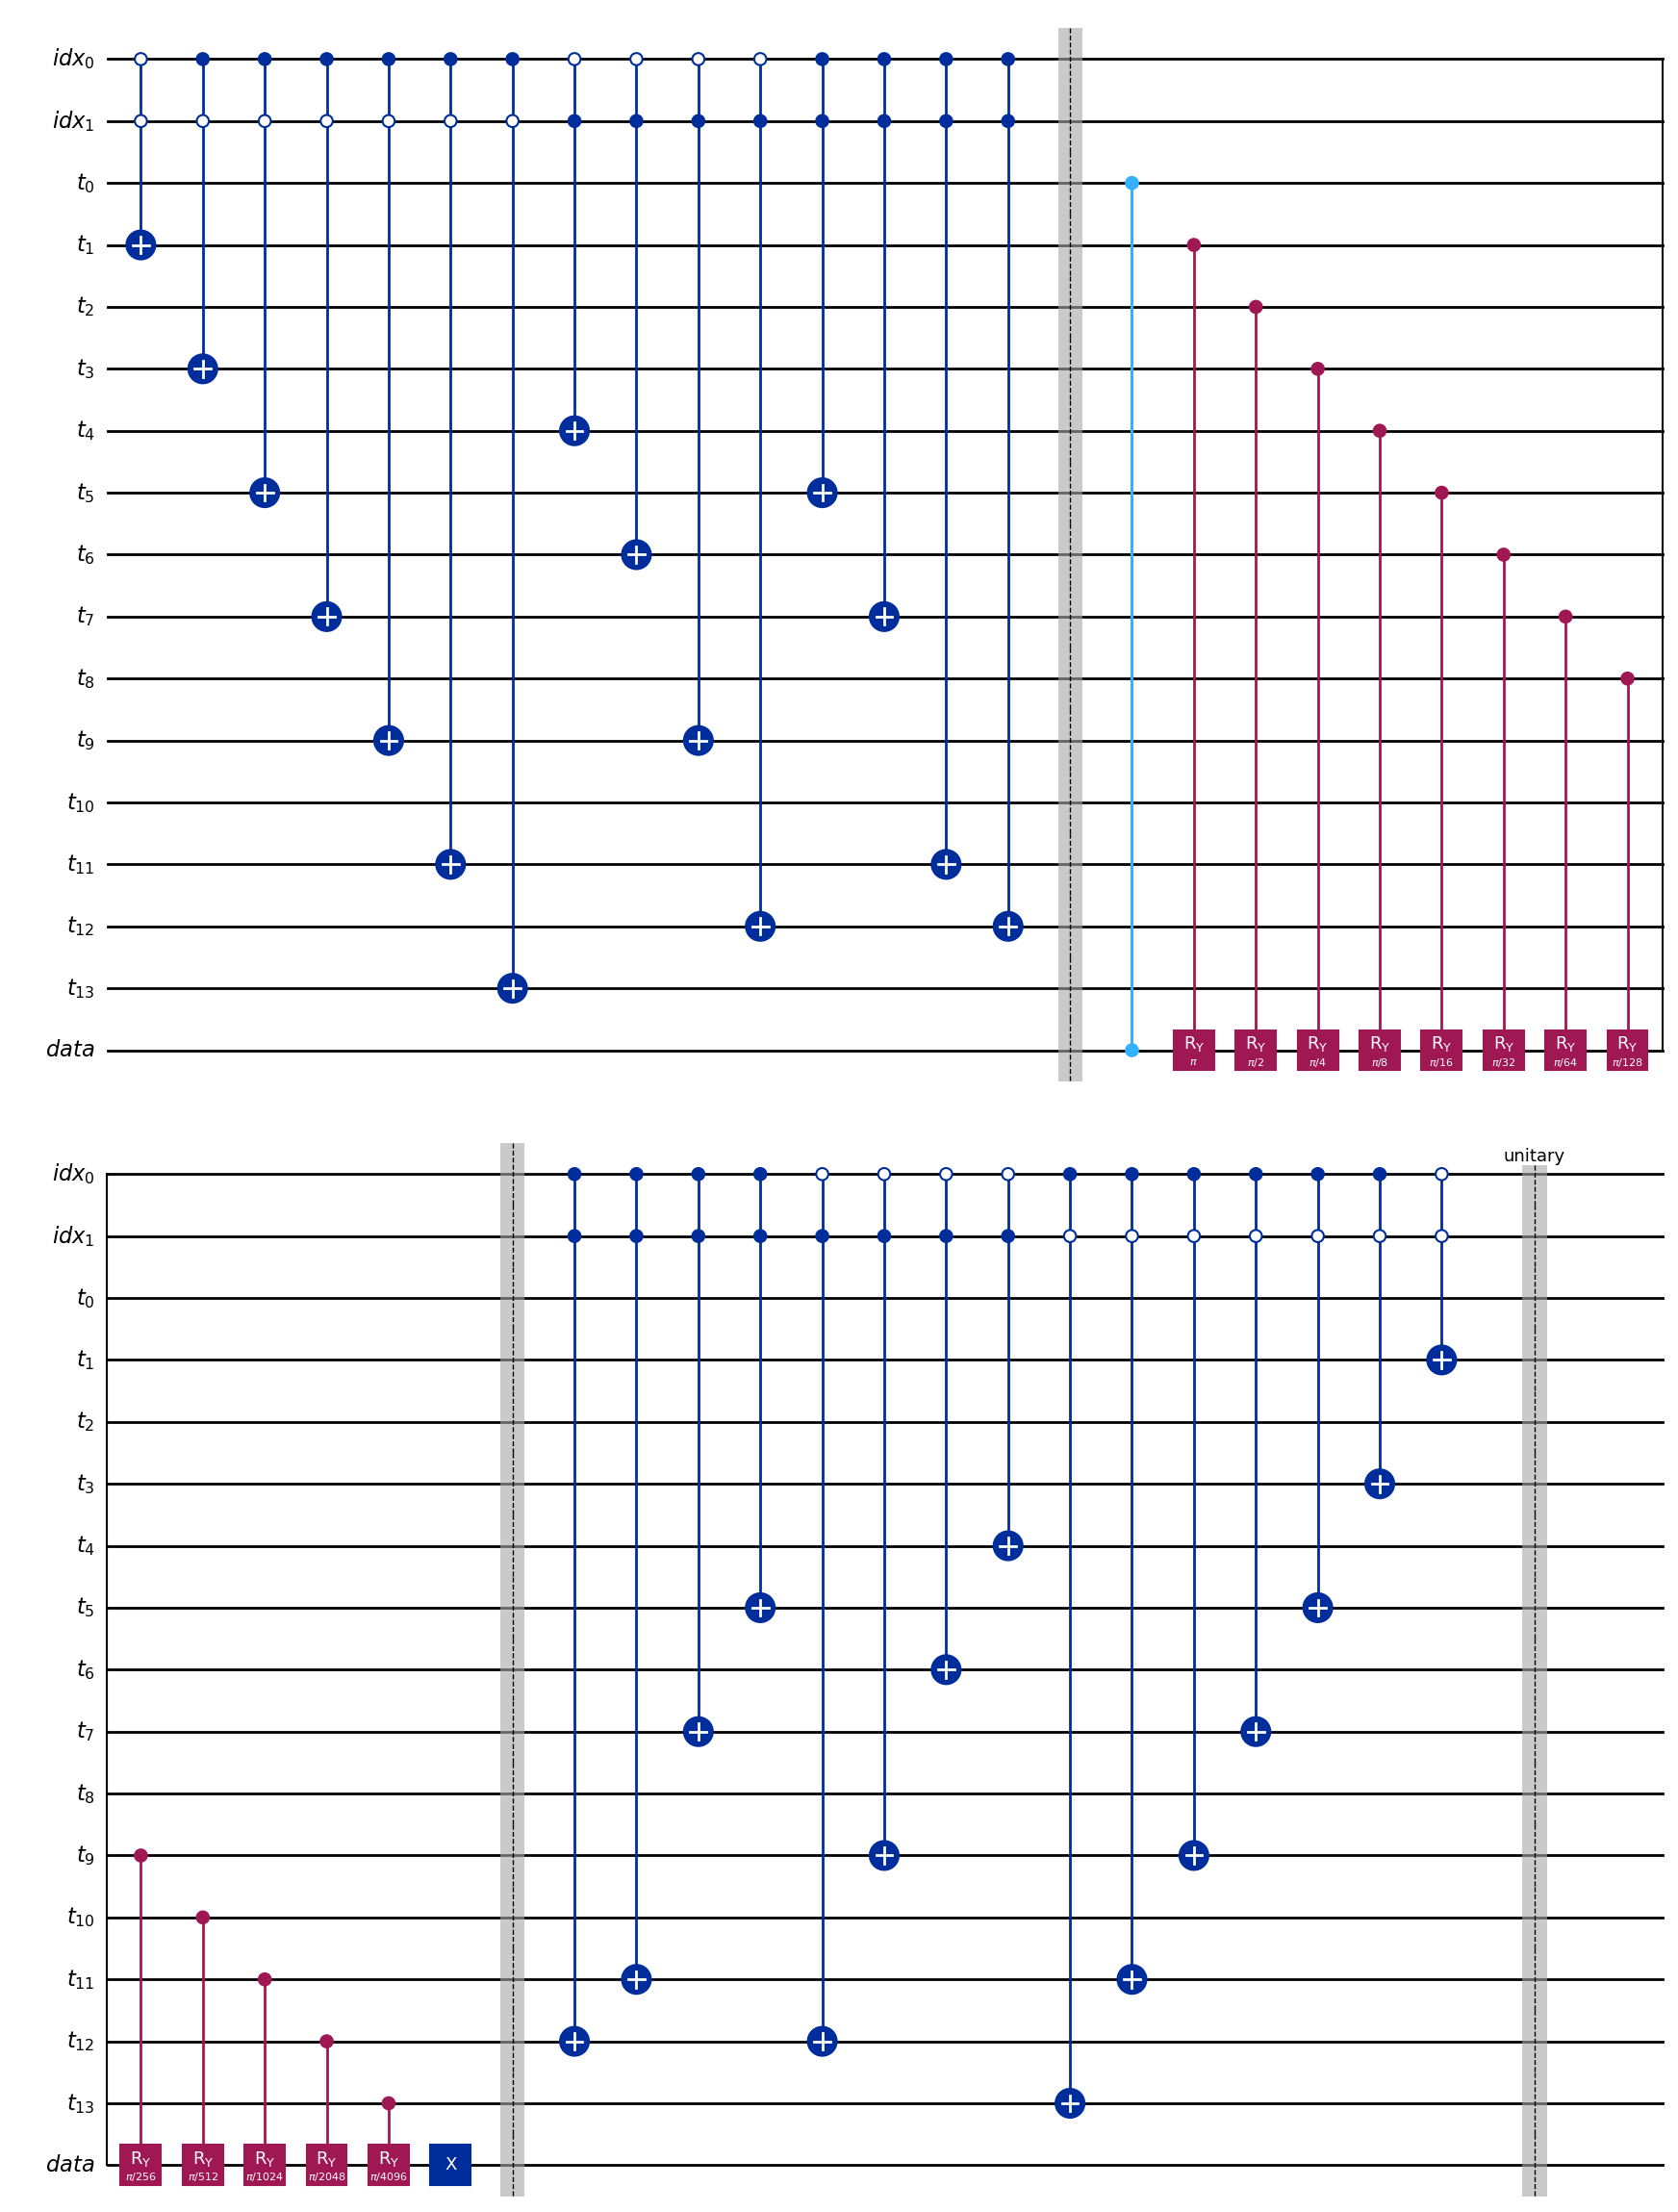

In [90]:
# Input vector
d = np.asarray([0.5,0.25,0.125,2**(-4)])
#d=[0.12467473,0.1763];
epsilon = 0.001
N=4
DiagonalBE,C=generate_Diagonal_Block_Encoding(d,epsilon)
DiagonalBE.save_unitary()
DiagonalBE.decompose().draw("mpl")

In [91]:
from qiskit.quantum_info import Operator

sim=AerSimulator(method="unitary")
full_circuit = transpile(DiagonalBE, sim)

result = sim.run(full_circuit).result()  # Run the circuit and get the result
mat = result.get_unitary(full_circuit) 

res=np.diag(mat[0:N,0:N])*C
print(res.real)

CircuitTooWideForTarget: 'Number of qubits (17) in circuit-400 is greater than maximum (14) in the coupling_map'

In [88]:
print(np.linalg.norm(res-np.asarray(d)))

0.0016579955307490005
